In [1]:
import os, random
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import hyperopt as ht
import librosa, librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

/home/ashok/kc/kagglenv/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def _initialize_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

random_state = 42
_initialize_seed(random_state)

In [3]:
data_dir = "../input/ravdess/"
df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))
df_valid = pd.read_csv(os.path.join(data_dir, "valid.csv"))

In [4]:
def load_signals(df, sr=44100, **kwargs):
    singals = []
    for row in tqdm(df.itertuples(), desc="Processing...", total=len(df)):
        audio_signal,_ = librosa.core.load(os.path.join(data_dir, row.filepath), sr=sr, offset=kwargs.get("offset", 0.25), duration=kwargs.get("duration", 2.5))
        singals.append(audio_signal)
    return np.array(singals, dtype=np.float32)

In [5]:
def get_mfcc_features(signal, postfeatures="standardize", return_dims=1):
    assert(postfeatures in ["standardize","normalize"])
    assert(return_dims in [1,2])

    # Get MFCC
    x = librosa.feature.mfcc(y=signal)

    # Postprocess
    if postfeatures=="standardize":
        x = StandardScaler().fit_transform(x.T).T
    elif postfeatures=="normalize":
        x = 2.*(x - x.min(axis=1).reshape(-1,1))/(x.max(axis=1)-x.min(axis=1)).reshape(-1,1) - 1
    
    # Return
    return x.ravel() if return_dims==1 else x

## Feature extraction

In [6]:
X_train = load_signals(df_train)
X_valid = load_signals(df_valid)

Processing...: 100%|██████████| 330/330 [00:18<00:00, 18.28it/s]


In [7]:
X_train_mfcc1D = np.array([get_mfcc_features(x, postfeatures="standardize", return_dims=1) for x in X_train])
X_valid_mfcc1D = np.array([get_mfcc_features(x, postfeatures="standardize", return_dims=1) for x in X_valid])

In [8]:
y_train = df_train["emotion"].values
y_valid = df_valid["emotion"].values

In [9]:
print(X_train_mfcc1D.shape, y_train.shape)
print(X_valid_mfcc1D.shape, y_valid.shape)

(990, 4320) (990,)
(330, 4320) (330,)


## Model: XGBoost

### Optimizing hyperparams

In [10]:
# Define space
space = {'max_depth': ht.hp.quniform("max_depth", 3, 18, 1),
    'gamma': ht.hp.uniform ('gamma', 1, 9),
    'reg_lambda' : ht.hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree' : ht.hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight' : ht.hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'seed': 42
}

# Objective function
def objective(space):
    clf=xgb.XGBClassifier(
        n_estimators=space['n_estimators'],
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']),
        eval_metric="auc",
        early_stopping_rounds=10
    )

    clf.fit(X_train_mfcc1D, y_train, eval_set=[(X_valid_mfcc1D, y_valid)], verbose=False)
    accuracy = accuracy_score(y_valid, clf.predict(X_valid_mfcc1D))
    
    return {'loss': -accuracy, 'status': ht.STATUS_OK}

# Run trials
trials = ht.Trials()
best_hyperparams = ht.fmin(
    fn = objective,
    space = space,
    algo = ht.tpe.suggest,
    max_evals = 50,
    trials = trials
)

# Obtain best hyperparams
print(best_hyperparams)

100%|██████████| 50/50 [01:28<00:00,  1.77s/trial, best loss: -0.3484848484848485]
{'colsample_bytree': 0.697604236265011, 'gamma': 2.1625624460965795, 'max_depth': 7.0, 'min_child_weight': 9.0, 'reg_lambda': 7.181656340878593}


### Model building and training

In [11]:
# [180,3,2.81,3.87,3.5,0.95]
# Find and fill best hyperparams for this model
xgbc = xgb.XGBClassifier(
    n_estimators=180,
    max_depth=6,
    gamma=2.5,
    reg_lambda=6,
    min_child_weight=10,
    colsample_bytree=0.75,
    eval_metric="auc",
    tree_method="gpu_hist"
)

xgbc.fit(X_train_mfcc1D, y_train)
y_hat_train = xgbc.predict(X_train_mfcc1D)
y_hat_valid = xgbc.predict(X_valid_mfcc1D)

### Evaluation

In [12]:
print("Accuracy (train):",accuracy_score(y_train, y_hat_train))
print("Accuracy (valid):",accuracy_score(y_valid, y_hat_valid))
print("F1 (train):",f1_score(y_train, y_hat_train, average="macro"))
print("F1 (valid):",f1_score(y_valid, y_hat_valid, average="macro"))

Accuracy (train): 0.9959595959595959
Accuracy (valid): 0.37272727272727274
F1 (train): 0.9962046181687604
F1 (valid): 0.36303169094477716


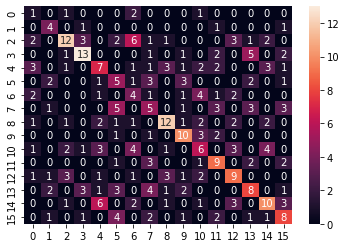

In [13]:
plt.figure(facecolor="white")
sns.heatmap(confusion_matrix(y_valid, y_hat_valid), annot=True)
plt.show()

### Predict single datapoint

In [14]:
xgbc.predict([X_valid_mfcc1D[0]])[0]

9

### Save

In [15]:
joblib.dump(xgbc, "../models/xgbc_v1_stdmfcc1D_2.5ms.joblib")

['../models/xgbc_v1_stdmfcc1D_2.5ms.joblib']

## Model: LSTM

### Define dataloader

In [10]:
# https://www.kaggle.com/code/huseinzol05/sound-augmentation-librosa/notebook
def pitch_shift(signal, sr=44100):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    return librosa.effects.pitch_shift(signal.astype('float32'), sr=sr, n_steps=pitch_change, bins_per_octave=bins_per_octave)

def value_augmentation(signal, low=1.5, high=3):
    dyn_change = np.random.uniform(low=low,high=high)
    return signal * dyn_change

def hpss(signal):
    return librosa.effects.hpss(signal.astype('float64'))[1]

def distribution_noise(signal):
    noise_amp = 0.005*np.random.uniform()*np.amax(signal)
    return signal.astype('float64') + noise_amp * np.random.normal(size=signal.shape[0])


class RavdessDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, paug=0.5) -> None:
        self.y = y
        self.X = X
        self.paug = paug
        self.transforms = {
            "pitch_shift":pitch_shift,
            "value_augmentation":value_augmentation,
            "hpss":hpss,
            "distribution_noise":distribution_noise
        }   

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        x, y = self.X[i], self.y[i]
        if np.random.random()<self.paug:
            transform_name = np.random.choice(list(self.transforms.keys()))
            x = self.transforms[transform_name](x)
        x = get_mfcc_features(x, postfeatures="standardize", return_dims=2)
        x = x.astype(np.float32).T
        return x, y

In [21]:
# Initialize dataset
train_dataset = RavdessDataset(X_train, y_train, paug=0.4)
valid_dataset = RavdessDataset(X_valid, y_valid, paug=0.0)

# Initialize dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=256)

### Model building

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 16

class GetLSTMFeatures(torch.nn.Module):
    def __init__(self, mode, batch_first=True) -> None:
        super().__init__()
        self.mode = mode
        self.batch_first = batch_first
    def forward(self, x):
        output, (hn, cn) = x
        if self.mode=="full":
            return output
        return output[:,-1,:] if self.batch_first else output[-1,:,:]

lstm_model = torch.nn.Sequential(
    torch.nn.LSTM(input_size=20, hidden_size=64, num_layers=3, dropout=0.2, batch_first=True),
    # GetLSTMFeatures(mode="full"),
    # torch.nn.LSTM(input_size=16, hidden_size=8, num_layers=2),
    GetLSTMFeatures(mode="last"),
    torch.nn.Linear(in_features=64, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32, out_features=n_classes)
).to(device)

### Training

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001, amsgrad=True)
epochs = 1000
verbose_step = 5
min_validation_loss = np.float32('inf')

# Epoch runner
for epoch in range(epochs):
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    # Training
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = lstm_model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        training_loss.append(loss.mean().item())
        training_accuracy.append((torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy().argmax(axis=1)==targets.cpu().detach().numpy()).sum()/len(targets))
    
    # Validation
    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            outputs = lstm_model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            validation_loss.append(loss.mean().item())
            validation_accuracy.append((torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy().argmax(axis=1)==targets.cpu().detach().numpy()).sum()/len(targets))
    
    # Verbose metrics
    if (epoch+1)%verbose_step==0:
        print(f"Epoch: {epoch+1}", end=", ")
        print("Training loss:", np.mean(training_loss), end=", ")
        print("Training accuracy:", np.mean(training_accuracy), end=", ")
        print("Validation loss:", np.mean(validation_loss), end=", ")
        print("Validation accuracy:", np.mean(validation_accuracy))
    
    # Save
    if np.mean(validation_loss) < min_validation_loss:
        min_validation_loss = np.mean(validation_loss)
        torch.save(lstm_model.state_dict(), "../models/lstm_v3_stdmfcc2D_2.5ms.pt")

Epoch: 5, Training loss: 2.735774517059326, Training accuracy: 0.09967096002252251, Validation loss: 2.713118076324463, Validation accuracy: 0.08350929054054054
Epoch: 10, Training loss: 2.4937174916267395, Training accuracy: 0.13789766328828829, Validation loss: 2.457340717315674, Validation accuracy: 0.1570945945945946
Epoch: 15, Training loss: 2.249662756919861, Training accuracy: 0.20272029842342343, Validation loss: 2.2025636434555054, Validation accuracy: 0.1746727195945946
Epoch: 20, Training loss: 2.077507972717285, Training accuracy: 0.24913780968468469, Validation loss: 2.0362237095832825, Validation accuracy: 0.21853885135135137
Epoch: 25, Training loss: 1.9909188449382782, Training accuracy: 0.27054300394144143, Validation loss: 1.9760764241218567, Validation accuracy: 0.24165962837837837
Epoch: 30, Training loss: 1.9442033171653748, Training accuracy: 0.30418602195945943, Validation loss: 1.9072966575622559, Validation accuracy: 0.2505278716216216
Epoch: 35, Training loss:

KeyboardInterrupt: 

In [14]:
print(min_validation_loss)

1.8167593479156494


## CNN

### Define dataloader

In [11]:
def display_spectrogram(spectrogram):
    fig, ax = plt.subplots(facecolor="white")
    img = librosa.display.specshow(spectrogram, x_axis='time',
                        y_axis='mel', sr=44100,
                        fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    plt.show()

In [16]:
class RavdessImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, paug=0.5) -> None:
        self.y = y
        self.X = X
        self.paug = paug
        self.transforms = {
            "pitch_shift":pitch_shift,
            "value_augmentation":value_augmentation,
            "hpss":hpss,
            "distribution_noise":distribution_noise
        }

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        x, y = self.X[i], self.y[i]
        if np.random.random()<self.paug:
            transform_name = np.random.choice(list(self.transforms.keys()))
            x = self.transforms[transform_name](x)
        x = librosa.feature.melspectrogram(y=x, sr=44100, n_fft=1380, hop_length=345)/255.
        return x.astype(np.float32), y

In [17]:
# Initialize dataset
train_imagedataset = RavdessImageDataset(X_train, y_train, paug=0.4)
valid_imagedataset = RavdessImageDataset(X_valid, y_valid, paug=0.0)

# Initialize dataloader
train_imagedataloader = torch.utils.data.DataLoader(train_imagedataset, batch_size=256)
valid_imagedataloader = torch.utils.data.DataLoader(valid_imagedataset, batch_size=256)

### Build model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 16

cnn_model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, 3, 2), # [?,1,128,320] -> [?,32,63,159]
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, 3, 2), # [?,32,63,159] -> [?,64,31,79]
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2), # [?,64,31,79] -> [?,64,15,39]
    torch.nn.Conv2d(64, 128, 3, 2), # [?,64,15,39] -> [?,128,7,19]
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2), # [?,128,7,19] -> [?,128,3,9]
    torch.nn.Flatten(),
    torch.nn.Linear(128*3*9, n_classes)
).to(device)

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001, amsgrad=True)
epochs = 1000
verbose_step = 10
min_validation_loss = np.float32('inf')

# Epoch runner
for epoch in range(epochs):
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    # Training
    for inputs, targets in train_imagedataloader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs.unsqueeze(axis=1).to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        training_loss.append(loss.mean().item())
        training_accuracy.append((torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy().argmax(axis=1)==targets.cpu().detach().numpy()).sum()/len(targets))
    
    # Validation
    with torch.no_grad():
        for inputs, targets in valid_imagedataloader:
            outputs = cnn_model(inputs.unsqueeze(axis=1).to(device))
            loss = criterion(outputs, targets.to(device))
            validation_loss.append(loss.mean().item())
            validation_accuracy.append((torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy().argmax(axis=1)==targets.cpu().detach().numpy()).sum()/len(targets))
    
    # Verbose metrics
    if (epoch+1)%verbose_step==0:
        print(f"Epoch: {epoch+1}", end=", ")
        print("Training loss:", np.mean(training_loss), end=", ")
        print("Training accuracy:", np.mean(training_accuracy), end=", ")
        print("Validation loss:", np.mean(validation_loss), end=", ")
        print("Validation accuracy:", np.mean(validation_accuracy))
    
    # Save
    if np.mean(validation_loss) < min_validation_loss:
        min_validation_loss = np.mean(validation_loss)
        torch.save(cnn_model.state_dict(), "../models/cnn_v1_stdmfcc2D_2.5ms.pt")

Epoch: 10, Training loss: 2.1340070962905884, Training accuracy: 0.35992046734234234, Validation loss: 2.422752618789673, Validation accuracy: 0.24751900337837837
Epoch: 20, Training loss: 1.5403814911842346, Training accuracy: 0.5243260838963963, Validation loss: 2.088812828063965, Validation accuracy: 0.3214210304054054
Epoch: 30, Training loss: 0.9721923023462296, Training accuracy: 0.7013566300675675, Validation loss: 1.9825977087020874, Validation accuracy: 0.36000844594594594
Epoch: 40, Training loss: 0.6203436627984047, Training accuracy: 0.8186057150900901, Validation loss: 1.8823872804641724, Validation accuracy: 0.41934121621621623
Epoch: 50, Training loss: 0.4816228896379471, Training accuracy: 0.8710409628378378, Validation loss: 1.8567222952842712, Validation accuracy: 0.45703125
Epoch: 60, Training loss: 0.3541188910603523, Training accuracy: 0.9022029842342343, Validation loss: 2.0359250903129578, Validation accuracy: 0.4259396114864865
Epoch: 70, Training loss: 0.343517